# Understanding the Data 




In [1]:
# import libaries
import numpy as np
import pandas as pd
import nltk, pprint
import matplotlib.pyplot as plt
import random
import itertools

# supress warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,multilabel_confusion_matrix
from sklearn.utils import class_weight



import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,SimpleRNN
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import TimeDistributed




In [2]:
# data_features=pd.read_csv('ner.csv',encoding="ISO-8859-1" ,error_bad_lines=False)
data=pd.read_csv("ner_dataset.csv",encoding="ISO-8859-1")

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
Sentence #    47959 non-null object
Word          1048575 non-null object
POS           1048575 non-null object
Tag           1048575 non-null object
dtypes: object(4)
memory usage: 32.0+ MB


In [4]:
# data_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050795 entries, 0 to 1050794
Data columns (total 25 columns):
Unnamed: 0         1050795 non-null int64
lemma              1050795 non-null object
next-lemma         1050795 non-null object
next-next-lemma    1050795 non-null object
next-next-pos      1050795 non-null object
next-next-shape    1050795 non-null object
next-next-word     1050795 non-null object
next-pos           1050795 non-null object
next-shape         1050794 non-null object
next-word          1050794 non-null object
pos                1050794 non-null object
prev-iob           1050794 non-null object
prev-lemma         1050794 non-null object
prev-pos           1050794 non-null object
prev-prev-iob      1050794 non-null object
prev-prev-lemma    1050794 non-null object
prev-prev-pos      1050794 non-null object
prev-prev-shape    1050794 non-null object
prev-prev-word     1050794 non-null object
prev-shape         1050794 non-null object
prev-word          1050794 n

In [5]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [6]:
data.columns=['Sentence', 'Word', 'POS', 'Tag']


In [7]:
data.Sentence.fillna(method="pad",inplace=True)

In [8]:
data.Sentence=data.Sentence.apply(lambda x: x[10:]).astype(int)

In [9]:
data.Sentence.max()

47959

In [10]:
words=list(set([i for i in data.Word.values ]))
tags=list(set([i for i in data.Tag.values ]))
word2ind={tag:i for i , tag in enumerate(words)}
tag2ind={tag:i for i , tag in enumerate(tags)}

ind2word={i:tag for tag, i in word2ind.items()}
ind2tag={i:tag for tag, i in tag2ind.items()}

In [11]:
len(words),len(tags)


(35178, 17)

In [12]:
# there are 47959 sentences in total

In [13]:
def preprocess_data():
    dataset=[]
    X=[]
    y=[]
    for index in range(1,data.Sentence.max()+1):
        sentence=data[data.Sentence == index]
        dataset.append(list(zip(sentence.Word.values,sentence.Tag.values)))
        X.append(sentence.Word.values.tolist())
        y.append(sentence.Tag.tolist())
    return dataset,X,y

In [14]:
dataset,X,y=preprocess_data()

In [15]:
print(X[0],y[0])
# dataset[:20]

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.'] ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [16]:
max_sec= max([len(sen) for sen in X])
print("max length of a sentence: ",max_sec)

max length of a sentence:  104


In [17]:
# word_tok=Tokenizer()
# word_tok.fit_on_texts(X)
# X_encoded=word_tok.texts_to_sequences(X)

# # tag_tok=Tokenizer()
# # tag_tok.fit_on_texts(y)
# # y_encoded=tag_tok.texts_to_sequences(y)

X_encoded=[[word2ind[word] for word in sen]for sen in X]
y_encoded=[[tag2ind[word] for word in sen]for sen in y]

In [18]:
print(y[0])
print(y_encoded[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']
[5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 15, 5, 5, 5, 5, 5]


In [19]:
# pad sequence

In [20]:
X_padded = pad_sequences(X_encoded, maxlen=max_sec, padding="post",value=len(words)-1)
y_padded = pad_sequences(y_encoded, maxlen=max_sec, padding="post",value=tag2ind['O'])
# # one-hot encoding
y_padded=np.array([to_categorical(i, num_classes = len(tags)) for i in y_padded])


In [21]:
print('X shape', X_padded.shape, 'y shape', y_padded.shape)

X shape (47959, 104) y shape (47959, 104, 17)


In [22]:
# X,y=X_padded,y_padded

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded, test_size=0.3, random_state=42)

In [24]:
len(X_train),len(X_test)

(33571, 14388)

In [25]:
# rnn
VOCABULARY_SIZE = len(word2ind.values()) + 1
EMBEDDING_VECTOR_LENGTH =64
OUTPUT_SIZE=len(tags)
MAX_SEQ_LENGTH=max_sec



In [26]:

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_VECTOR_LENGTH,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(OUTPUT_SIZE, activation='softmax')))

In [27]:
def custom_loss(y_true, y_pred):
    class_weights = class_weight.compute_class_weight('balanced',
                                                list(tag2ind.values()),
                                                 list(itertools.chain(*y_encoded)))
    
    cross_entropy = tf.reduce_mean(
        tf.nn.weighted_cross_entropy_with_logits(
            logits=y_pred, labels=y_true, pos_weight=class_weights))
            
        
    return cross_entropy

In [37]:
rnn_model.compile(loss      =  custom_loss,
                  optimizer =  'adam',
                 metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [38]:
# check summary of the model
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 64)           2251456   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 104, 64)           8256      
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           1105      
Total params: 2,260,817
Trainable params: 9,361
Non-trainable params: 2,251,456
_________________________________________________________________


In [39]:

rnn_training = rnn_model.fit(X_train, y_train,validation_split=0.2, batch_size=128, epochs=10)

Epoch 1/10
210/210 [==============================] - 36s 171ms/step - loss: 0.6627 - categorical_accuracy: 0.9678 - val_loss: 0.6628 - val_categorical_accuracy: 0.9681
Epoch 2/10
210/210 [==============================] - 37s 177ms/step - loss: 0.6627 - categorical_accuracy: 0.9678 - val_loss: 0.6628 - val_categorical_accuracy: 0.9681
Epoch 3/10
210/210 [==============================] - 33s 159ms/step - loss: 0.6627 - categorical_accuracy: 0.9678 - val_loss: 0.6628 - val_categorical_accuracy: 0.9681
Epoch 4/10
210/210 [==============================] - 33s 158ms/step - loss: 0.6627 - categorical_accuracy: 0.9679 - val_loss: 0.6628 - val_categorical_accuracy: 0.9684
Epoch 5/10
210/210 [==============================] - 33s 159ms/step - loss: 0.6626 - categorical_accuracy: 0.9681 - val_loss: 0.6628 - val_categorical_accuracy: 0.9685
Epoch 6/10
210/210 [==============================] - 33s 159ms/step - loss: 0.6626 - categorical_accuracy: 0.9682 - val_loss: 0.6628 - val_categorical_acc

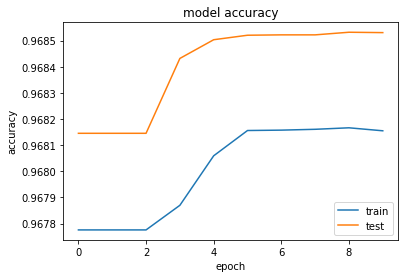

In [40]:
plt.plot(rnn_training.history['categorical_accuracy'])
plt.plot(rnn_training.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [41]:
pred=rnn_model.predict(X_test)

# pred.shape




In [42]:
# # pred[0][3].argmax(axis=-1)
# # pred[225][0]

# t=np.zeros(pred.shape,dtype=np.int)
# for i , p in enumerate(pred):
#     for j,s in enumerate(p):
#         t[i][j][np.argmax(s)]=1
        
        

In [43]:
# print(classification_report(y_test, t,target_names=list(tag_tok.word_index.keys())))
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(y_test,pred)
m.result().numpy()

0.96801955

In [44]:
rnn_model.evaluate(X_test,y_test)

450/450 [==============================] - 8s 17ms/step - loss: 0.6632 - categorical_accuracy: 0.9680


[0.6631669402122498, 0.9680195450782776]

In [45]:
print(classification_report([ind2tag[np.argmax(i)] for rand in range(len(y_test)) for i in  y_test[rand]],[ind2tag[np.argmax(i)] for rand in range(len(y_test)) for i in  pred[rand]]))

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00       125
       B-eve       0.00      0.00      0.00        90
       B-geo       0.00      0.00      0.00     11488
       B-gpe       0.00      0.00      0.00      4787
       B-nat       0.00      0.00      0.00        74
       B-org       0.00      0.00      0.00      5896
       B-per       0.83      0.12      0.21      5141
       B-tim       0.00      0.00      0.00      6109
       I-art       0.00      0.00      0.00        90
       I-eve       0.00      0.00      0.00        79
       I-geo       0.00      0.00      0.00      2236
       I-gpe       0.00      0.00      0.00        63
       I-nat       0.00      0.00      0.00        20
       I-org       0.00      0.00      0.00      4988
       I-per       0.00      0.00      0.00      5201
       I-tim       0.00      0.00      0.00      2031
           O       0.97      1.00      0.98   1447934

    accuracy              

In [46]:
# test a seq

In [47]:
rand=np.random.randint(0,X_test.shape[0])
print(rand)
print([ind2word[i] if i !=len(words)-1 else 'padd' for i in  X_test[rand]])
print([ind2tag[np.argmax(i)] for i in  y_test[rand]])
print([ind2tag[np.argmax(i)] for i in  pred[rand]])

6168
['President', 'Rakhmon', 'has', 'also', 'warned', 'of', 'potential', 'health', 'hazards', 'stemming', 'from', 'mobile', 'phone', 'use', '.', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd', 'padd']
['B-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

In [48]:
class_weight.compute_class_weight('balanced',
                                                list(tag2ind.values()),
                                                 list(itertools.chain(*y_encoded)))

array([2.00262605e+02, 3.57549605e+00, 1.53435031e+02, 9.44866458e+00,
       1.20942907e+03, 6.94676502e-02, 1.63853157e+00, 3.67498107e+00,
       8.31951475e+00, 2.07679739e+02, 2.43797954e+02, 3.11519608e+02,
       3.63042274e+00, 3.03353575e+00, 3.06214975e+00, 3.88663405e+00,
       3.06870061e+02])